## Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install os
!pip install wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import wfdb

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -nc https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip
!unzip -n training_setA.zip

File ‘training_setA.zip’ already there; not retrieving.

Archive:  training_setA.zip


In [3]:
def load_single_file(file_path):
    df = pd.read_csv(file_path, sep="|")
    df['PatientID'] = file_path.split(os.sep)[-1][:-4]
    df['Hour'] = df.index
    keep_cols = ['PatientID', 'Age', 'Gender', 'SepsisLabel', 'Hour',
                 'HR', 'O2Sat', 'SBP', 'DBP', 'Resp']
    df = df[keep_cols]
    df.rename(columns={'Gender': 'Sex', 'SepsisLabel': 'HasSepsis'}, inplace=True)
    return df

def create_final_table():
    final_df = pd.DataFrame()
    patient_list = range(1, 11)
    patient_list = [f'p{str(s).zfill(6)}.psv' for s in patient_list]
    for f in patient_list:
        df = load_single_file(os.path.join("training", f))
        final_df = pd.concat([final_df, df])
    final_df.to_csv('sepsis.csv',index=False)
create_final_table()

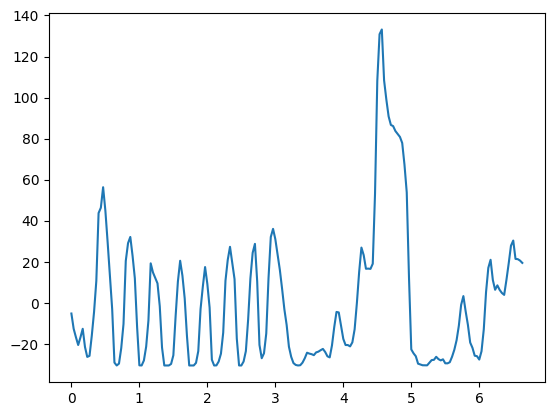

In [4]:
# Load the PPG data
user = '100004'
signals, fields = wfdb.rdsamp(f'{user}_PPG', pn_dir=f'butppg/{user}')
ppg = signals.flatten()
ppg = ppg[:200]
ppg -= ppg.mean()
fs = fields['fs']
ppg_time = np.arange(len(ppg))/fs

# Save it in a DataFrame
df = pd.DataFrame()
df['Time'] = ppg_time
df['PPG'] = ppg
df.to_csv('ppg.csv', index=False)

plt.figure()
plt.plot(df['Time'], df['PPG'])
plt.show()

# Instructions

To get full credit for this assignment, we should be able to run your entire notbook from start to finish without any errors. You can check this yourself by selecting "Runtime" > "Run all" in the Google Colab menu.

# Exercise 1: Working with PPG Data

This exercise will involve the same PPG we used in the last homework assignment.

In [5]:
df = pd.read_csv("ppg.csv")
df

,Time,PPG
0,0.000000,-5.088518
1,0.033333,-12.501646
2,0.066667,-16.617164
3,0.100000,-20.412686
4,0.133333,-16.688403
...,...,...
195,6.500000,30.430563
196,6.533333,21.500355
197,6.566667,21.367937
198,6.600000,20.677867


**(Part 1)** Write code that will calculate the sampling rate of this signal.

In [6]:
f = 1/(df['Time'].diff().mean())
f

30.0

**(Part 2)** If we were to analyze this data in the frequency domain, at which frequency range would we expect to see the most content? We are looking for a ballpark answer, but your answer should include a brief explanation.

*Hint:* Think about translating "beats per minute" to "Hertz".

A resting heart rate in adults ranges from around 60 to 100 beats per minute. The conversion to Hertz would be 60 beats/60 seconds = 1 Hz to 100 beats/60 seconds = 1.67 Hz.

**(Part 3)** To prepare this data so that we can generate FFTs and spectrograms, convert it into two `numpy` arrays:
1. A 1D array for the `'Time'` column
2. A 1D array for the `'PPG'` column minus the average value of that column so that the resulting array has an average of 0

In [7]:
time = np.array(df['Time'])
PPG = np.array(df['PPG']-df['PPG'].mean())

**(Part 4)** Plot the FFT of the PPG signal. The function that we created during class has been copied below for your convenience, but you will need to make sure that the inputs are correct and make the plot informative.

In [8]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
def show_fft(x, y, fs=1000, time_ylim=None, fft_xlim_max=None):
    """
    Shows the time-domain signal and the corresponding FFT
    x: the timestamps of the signal as a Numpy array
    y: the values of the signal as a Numpy array
    fs: the sampling rate of our signal
    time_ylim: the boundaries of the y-axis for the time-domain plot
    fft_xlim_max: the right boundary for the x-axis of the FFT plot,
    indicating the highest frequency we care to view
    """
    # Compute the FFT
    fft_mag = np.abs(fft(y))
    freqs = fftfreq(len(y), 1/fs)

    # Keep the components associated with positive frequencies
    pos_freq_idxs = freqs >= 0
    freqs = freqs[pos_freq_idxs]
    fft_mag = fft_mag[pos_freq_idxs]

    # Show the signal in the time domain
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(x, y)
    plt.xlabel('Time (s)')
    plt.ylabel('PPG')
    if time_ylim:
        plt.ylim(time_ylim[0], time_ylim[1])
    plt.title('Time Domain')

    # Show the signal in the frequency domain
    plt.subplot(1, 2, 2)
    plt.stem(freqs, fft_mag, markerfmt=" ", basefmt="-")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim(-0.1, fft_xlim_max if fft_xlim_max else freqs.max())
    plt.title('Frequency Domain')
    plt.show()

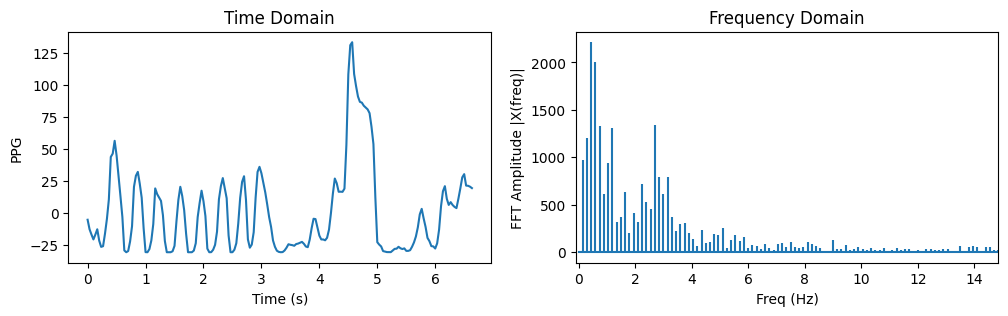

In [9]:
show_fft(time, PPG, f)

**(Part 5)** How does the FTT align or misalign with the expectations you laid out in Part 2?

The FFT aligns with the expectations laid out in part 2 as the strongest power is found in frequencies around 1 to 1.6 Hz. However there is also strong power in frequencies of magnitudes higher than expected, which may be due to noise or artefact.

**(Part 6)** Plot the spectrogram of the PPG signal. The function that we created during class has been copied below for your convenience, but you will need to make sure that the inputs are correct and make the plot informative.

In [10]:
from scipy import signal
def show_spectrogram(x, y, fs=1000, win_len=1, win_percent_overlap=12.5,
                     time_ylim=None, fft_xlim_max=None):
    """
    Shows the time-domain signal and the corresponding spectrogram
    x: the timestamps of the signal as a Numpy array
    y: the values of the signal as a Numpy array
    fs: the sampling rate of our signal
    win_len: the length of the window in seconds
    win_percent_overlap: the percentage of overlap between consecutive windows
    time_ylim: the boundaries of the y-axis for the time-domain plot
    fft_xlim_max: the top boundary for the y-axis of the spectrogram,
    indicating the highest frequency we care to view
    """
    # Compute the window parameters
    num_window_points_len = int(fs*win_len)
    num_window_points_overlap = int(num_window_points_len*(win_percent_overlap/100))

    # Compute the spectrogram
    freqs, times, spectro = signal.spectrogram(y, fs,
                                               nperseg=num_window_points_len,
                                               noverlap=num_window_points_overlap)

     # Show the signal in the time domain
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(x, y)
    plt.xlabel('Time (s)')
    plt.ylabel('PPG')
    if time_ylim:
        plt.ylim(time_ylim[0], time_ylim[1])
    plt.title('Time Domain')

    # Show the signal in the frequency domain
    plt.subplot(1, 2, 2)
    cmesh = plt.pcolormesh(times, freqs, spectro, shading='gouraud')
    plt.colorbar(cmesh, ax=plt.gca())
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(-0.1, fft_xlim_max if fft_xlim_max else freqs.max())
    plt.title('Frequency Domain')
    plt.show()

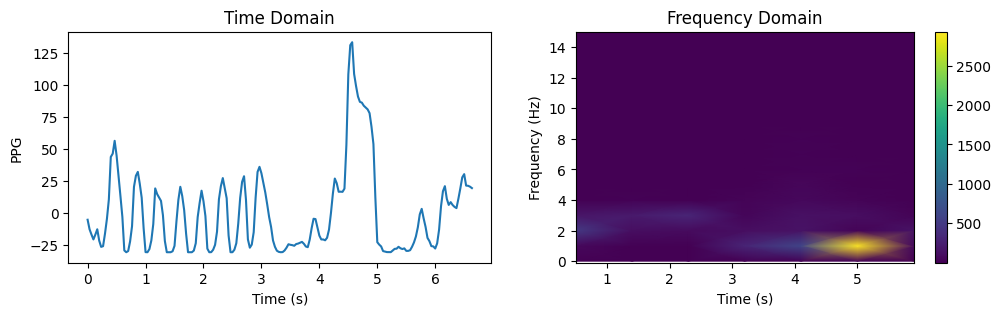

In [11]:
show_spectrogram(time, PPG, f)

**(Part 7)** How does the spectrogram align or misalign with the expectations you laid out in Part 2?

The spectrogram aligns with the expectations laid out in part 2, as there is strong power in frequencies between 1-1.67 Hz. However, there is some power in higher frequencies potentially representing noise or artefact.


**(Part 8)** Apply a filter to emphasize the frequency content in the range you specified in **(Part 2)** and to deemphasize the noisy data at the end of the signal. This filter is not expected to completely eliminate the noise, but it should make the apparent heart rate of the patient more apparent. The functions that we created during class have been copied below for your convenience, but you do not need use both of them.

Show your filtered signal with its FFT, similar to what you did for **(Part 4)**.

In [12]:
from scipy.signal import butter, filtfilt

def butter_lowpass(data, fs, cutoff, order=5):
    """
    Apply a low-pass filter to time-series data
    data: the values of the time-series data (not the timestamps)
    fs: the sampling rate
    cutoff: the cutoff frequency
    order: the order of the Butterworth filter
    """
    # Define the cutoff frequency in terms of the Nyquist frequency of the signal
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq

    # Compute the low-pass filter
    b, a = butter(order, normal_cutoff, btype='lowpass')

    # Apply the filter
    y = filtfilt(b, a, data)
    return y

In [13]:
from scipy.signal import butter, filtfilt

def butter_bandpass(data, fs, lower_cutoff, upper_cutoff, order=5):
    """
    Apply a band-pass filter to time-series data
    data: the values of the time-series data (not the timestamps)
    fs: the sampling rate
    lower_cutoff: the lower cutoff frequency
    upper_cutoff: the upper cutoff frequency
    order: the order of the Butterworth filter
    """
    # Define the cutoff frequency in terms of the Nyquist frequency of the signal
    nyq = 0.5 * fs
    normal_lower_cutoff = lower_cutoff / nyq
    normal_upper_cutoff = upper_cutoff / nyq

    # Compute the band-pass filter
    b, a = butter(order, [normal_lower_cutoff, normal_upper_cutoff], btype='bandpass')

    # Apply the filter
    y = filtfilt(b, a, data)
    return y

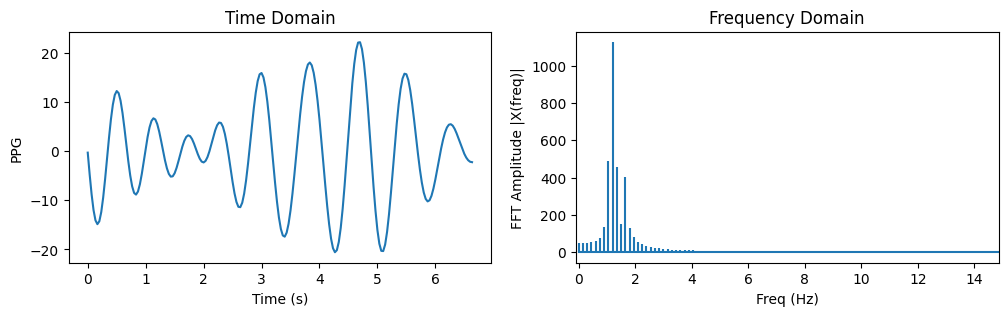

In [14]:
filtered = butter_bandpass(PPG, f, 1, 1.67)
show_fft(time, filtered, f)

**(Part 9)** Write code that identifies the peak frequency in the FFT of your filtered signal. This value should represent the average heart rate of the person and therefore fall within the range you specified in **(Part 2)**.

In [15]:
# Calculate FFT of filtered signal
fft_mag_filtered = np.abs(fft(filtered)) # Get magnitudes
freqs_filtered = fftfreq(len(filtered), 1/f)

# Find peak frequency
pos_freq_idxs_filtered = freqs_filtered >= 0
freqs_filtered = freqs_filtered[pos_freq_idxs_filtered]
fft_mag_filtered = fft_mag_filtered[pos_freq_idxs_filtered]

peak_freq = freqs_filtered[np.argmax(fft_mag_filtered)]
peak_freq

1.2